# This notebook demonstrates how to monitor the training of a classifier on CIFAR-10
##### We follows this tutorial: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


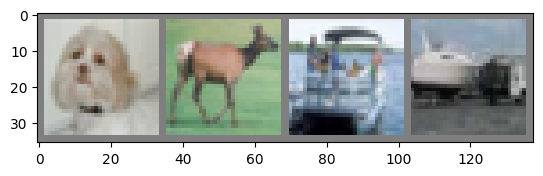

dog   deer  ship  ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from pytorch_module_monitor import ModuleMonitor
import torch

# create the training monitor
import logging
logging.basicConfig(level=logging.WARNING)
training_monitor = ModuleMonitor(monitor_step_fn=lambda step: step % 100 == 0,
                                 excluded_modules_regex=r"^.*(pool).*") # exclude the pooling layer. we currently do not support monitoring of modules that are called multiple times per forward pass

# add some metrics
training_monitor.add_activation_metric("l2norm", lambda activations: torch.linalg.vector_norm(activations, ord=2, dim=-1))
training_monitor.add_activation_metric("min", lambda activations: torch.min(activations, dim=-1).values, "conv1", metric_aggregation_fn=torch.min)
training_monitor.add_activation_metric("max", lambda activations: torch.max(activations, dim=-1).values, "conv2", metric_aggregation_fn=torch.max)

training_monitor.add_parameter_metric("l2norm", lambda parameters: torch.linalg.vector_norm(parameters.flatten(), ord=2))
training_monitor.add_parameter_metric("max", lambda parameters: torch.max(parameters.flatten()))
training_monitor.add_parameter_metric("opnorm", lambda parameters: torch.linalg.matrix_norm(parameters, ord=2), r"fc\d*\.weight") # operator norm of fully connected layers

training_monitor.add_gradient_metric("l2norm", lambda gradients: torch.linalg.vector_norm(gradients.flatten(), ord=2))

# provide the module that we want to monitor
training_monitor.set_module(net) 

In [8]:
import wandb

wandb.init(project="cifar-10", entity='sbordt-University of Tübingen')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sbordt (sbordt-University of Tübingen). Use `wandb login --relogin` to force relogin


In [9]:
gradient_step = 1
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ### Tell the monitor that we are starting a new gradient step ###
        training_monitor.begin_step(gradient_step)

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        ### Tell the monitor to monitor parameters and gradients now ###
        training_monitor.monitor_parameters()
        training_monitor.monitor_gradients()

        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

        gradient_step += 1

        ### Tell the monitor that we are done with the step. This will aggregate the metrics. ###
        training_monitor.end_step()

        # log everything to wandb
        metrics = {
            "loss": loss.item(),
            "epoch": epoch,
            "step": gradient_step,
        }
        metrics.update(training_monitor.get_step_metrics())
        wandb.log(metrics)

print('Finished Training')

[1,  2000] loss: 2.209
[1,  4000] loss: 1.887
[1,  6000] loss: 1.687
[1,  8000] loss: 1.557
[1, 10000] loss: 1.495
[1, 12000] loss: 1.450
[2,  2000] loss: 1.374
[2,  4000] loss: 1.346
[2,  6000] loss: 1.330
[2,  8000] loss: 1.296
[2, 10000] loss: 1.304
[2, 12000] loss: 1.277
[3,  2000] loss: 1.209
[3,  4000] loss: 1.220
[3,  6000] loss: 1.177



Aborted!


KeyboardInterrupt: 

Thread SenderThread:
Traceback (most recent call last):
  File "/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/wandb/sdk/internal/internal_util.py", line 48, in run
    self._run()
  File "/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/wandb/sdk/internal/internal_util.py", line 99, in _run
    self._process(record)
  File "/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/wandb/sdk/internal/internal.py", line 327, in _process
    self._sm.send(record)
  File "/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/wandb/sdk/internal/sender.py", line 386, in send
    send_handler(record)
  File "/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/wandb/sdk/internal/sender.py", line 1361, in send_output_raw
    output_raw.start()
  File "/home/sebastian/anaconda3/envs/tmcd/lib/python3.12/site-packages/wandb/sdk/internal/sender.py", line 193, in start
    self._writer_thr.start()
  File "/home/sebastian/anaconda3/env

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
training_monitor.get_all_metrics()

AttributeError: 'ModuleMonitor' object has no attribute 'log_dict'

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7bc2bccb60f0>> (for post_run_cell), with arguments args (<ExecutionResult object at 7bc3007ae000, execution_count=11 error_before_exec=None error_in_exec='ModuleMonitor' object has no attribute 'log_dict' info=<ExecutionInfo object at 7bc3007ad340, raw_cell="training_monitor.get_all_metrics()" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/sebastian/Documents/GitHub/pytorch-module-monitor/examples/metrics.ipynb#X14sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe